# Validation


## Overview


The goal of the Niche Validation is to compare the potential vegetation types as
determined by Niche Vlaanderen with the actual presence of vegetation types, e.g.
as mapped in a vegetation map such as the Biological Valuation Map - [Biologische waarderingskaart (BWK)]( https://www.vlaanderen.be/inbo/de-biologische-waarderingskaart/wat-is-de-biologische-waarderingskaart/)

The vegetation map should be a spatial vector file (e.g. a shapefile) with:

- up to 9 habitat types in fields named HAB1-HAB9,
- the proportion of the shape they occupy in fields named pHAB1-pHAB9 (0-100 %). 
 
*Note that the field names are not case sensitive (hab1, phab1 can be used without any conversion) and HAB2 until HAB9/pHAB2 until pHAB9 are facultative*.

The habitat types in the vegetation map should be described using the official abbreviations of the Natura 2000 habitats and/or the regional important biotopes. Since those are different from the vegetation types in Niche, we provide a [mapping
table](https://github.com/inbo/niche_vlaanderen/blob/master/niche_vlaanderen/system_tables/hab_niche_join.csv) to link both vegetation typologies.

In the next steps, a (fictive) **niche model** is **created**. 

In [1]:
from niche_vlaanderen import Niche
nv = Niche()
nv.run_config_file("../tests/data/bwk_tiny/tiny.yaml")

Next a **validation object** is **created** which contains the vegetation map with extra columns NICH_x_y for the corresponding niche vegetation types (x refers to the xth habitat, HABx). Note that some vegetation types of the Biological Valuation Map used in this example cannot be mapped to niche vegetation types (e.g. `gh` = 'geen habitat'/'no habitat' in the example below).

The `zonal_statistics` module is used in the background to calculate the potential vegetation for every shape.
Note the progress bar: in this example it is going fast, but for larger areas, calculation may take up to 10 minutes.

In [2]:
from niche_vlaanderen.validation import NicheValidation
validation = NicheValidation(niche=nv, map="../tests/data/bwk_tiny/bwk_clip.shp")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 56.79it/s]


It is possible to check the **mapping per vegetation** type by checking the `map` attribute of the validation object:

In [3]:
validation.map

,HAB1,pHAB1,HAB2,pHAB2,HAB3,pHAB3,HAB4,pHAB4,HAB5,pHAB5,...,NICH_1_1,NICH_1_2,NICH_2_1,NICH_2_2,NICH_3_1,NICH_3_2,NICH_4_1,NICH_4_2,NICH_5_1,NICH_5_2
0,2310,100,None,0,None,0,None,0,None,0,...,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2190_mp,100,None,0,None,0,None,0,None,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,rbbsm,100,None,20,None,0,None,0,None,0,...,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,gh,80,rbbvos,20,None,0,None,0,None,0,...,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9160,100,None,0,None,0,None,0,None,0,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let us plot the vegetation map together with the niche predictions for niche vegetation type 5 that will be used further as an example.

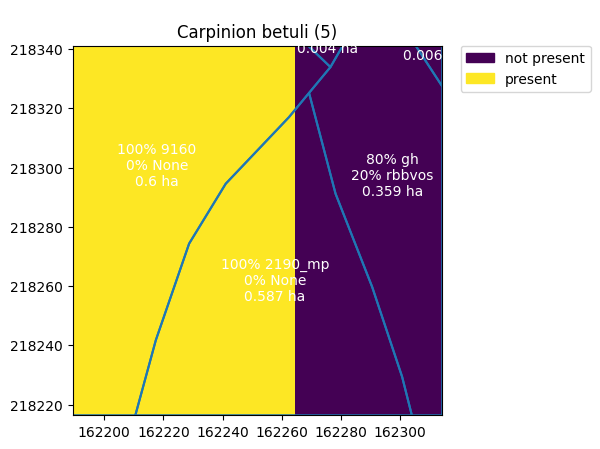

In [4]:
mymap = validation.map.boundary.plot(ax=nv.plot(5)) 
validation.map.apply(lambda x: mymap.annotate(text=str(x['pHAB1']) + "% " + str(x['HAB1']) + "\n" + 
                                                     str(x['pHAB2']) + "% " + str(x['HAB2']) + "\n" + 
                                                     str(round(x['area_shape'], 3)) + " ha", 
                                                 xy=x.geometry.centroid.coords[0], 
                                                 ha='center',
                                                    color = "white"), 
                           axis=1);

A **summarized table** containing scores of the validation for the whole study area can be found by calling the `summary` method.

In [5]:
validation.summary

,area_effective,nonpot,nonpot_phab,pot,polygon_count,score,score_phab
vegetation,,,,,,,
5,0.595324,0.014945,0.014945,0.580379,1.0,97.48954,97.48954
19,0.071738,0.358689,0.071738,0.000000,1.0,0.00000,0.00000
27,0.004982,0.004982,0.004982,0.000000,1.0,0.00000,0.00000
28,0.004982,0.004982,0.004982,0.000000,1.0,0.00000,0.00000


with:

- area_effective: total area in ha with a given vegetation type, taking into account the proportion of the vegetation within each shape (pHAB)
- nonpot: total area with actual presence according to the vegetation map, but without potential presence according to niche
- nonpot_phab: total area with actual presence according to the vegetation map, but without potential presence according to niche (taking pHAB into account). We recommend using nonpot_phab instead of nonpot.
- pot: total area with actual presence according to the vegetation map and with potential presence according to niche
- polygon count: number of shapes with the actual vegetation type according to the vegetation map. If there are few polygons, the final score should be taken with caution.
- score: proportion of the total area with potential presence according to niche, compared to the total area of polygons with presence of a vegetation according to the vegetation map
- score_phab: proportion of the total area with potential presence according to niche, compared to the actual area of a vegetation type according to the vegetation map (i.e. taking pHAB into account). We recommend using score_phab instead of score.


**Intermediate tables** giving values for each shape can be retrieved by their names:

* veg_present: table showing whether the vegetation type is present in this polygon according to the vegetation map (1 or 0)
* area_effective: area of the shape in ha taking into account the proportion of the vegetation = area polygon * pHAB
* area_nonpot: area with actual presence according to the vegetation map, but without potential presence according to niche
* area_nonpot_phab: area with actual presence according to the vegetation map, but without potential presence according to niche (taking pHAB into account)
  * calculated as: If([area_effective]>[area_pot];[area_effective]-[area_pot];0)
  * Note we recommend using area_nonpot_phab instead of area_nonpot.
* area_pot: area with actual presence according to the vegetation map and with potential presence predicted by niche
* area_pot_perc: proportion (%) of the area with correct predicted area (not taking into account pHAB)
  * calculated as: 100*[area_pot]/ ([area_pot]+[area_nonpot])
* area_pot_perc_phab: proportion (%) of the area with correct predicted area (taking into account pHAB)
  * calculated as: If([area_pot]<[area_effective];100*[ area_pot]/([area_effective]);100)
  * Note we recommend using area_pot_perc_phab instead of area_pot_perc.

In [6]:
validation.veg_present

vegetation,5,19,27,28
shape_id,,,,
0,NaN,NaN,NaN,1.0
1,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,NaN
3,NaN,1.0,NaN,NaN
4,1.0,NaN,NaN,NaN


In [7]:
validation.area_effective

vegetation,5,19,27,28
shape_id,,,,
0,NaN,NaN,NaN,0.004982
1,NaN,NaN,NaN,NaN
2,NaN,NaN,0.004982,NaN
3,NaN,0.071738,NaN,NaN
4,0.595324,NaN,NaN,NaN


In [8]:
validation.area_nonpot

vegetation,5,19,27,28
shape_id,,,,
0,NaN,NaN,NaN,0.004982
1,NaN,NaN,NaN,NaN
2,NaN,NaN,0.004982,NaN
3,NaN,0.358689,NaN,NaN
4,0.014945,NaN,NaN,NaN


In [9]:
validation.area_nonpot_phab

vegetation,5,19,27,28
shape_id,,,,
0,NaN,NaN,NaN,0.004982
1,NaN,NaN,NaN,NaN
2,NaN,NaN,0.004982,NaN
3,NaN,0.071738,NaN,NaN
4,0.014945,NaN,NaN,NaN


In [10]:
validation.area_pot

vegetation,5,19,27,28
shape_id,,,,
0,NaN,NaN,NaN,0.0
1,NaN,NaN,NaN,NaN
2,NaN,NaN,0.0,NaN
3,NaN,0.0,NaN,NaN
4,0.580379,NaN,NaN,NaN


In [11]:
validation.area_pot_perc

vegetation,5,19,27,28
shape_id,,,,
0,NaN,NaN,NaN,0.0
1,NaN,NaN,NaN,NaN
2,NaN,NaN,0.0,NaN
3,NaN,0.0,NaN,NaN
4,97.48954,NaN,NaN,NaN


In [12]:
validation.area_pot_perc_phab

vegetation,5,19,27,28
shape_id,,,,
0,NaN,NaN,NaN,0.0
1,NaN,NaN,NaN,NaN
2,NaN,NaN,0.0,NaN
3,NaN,0.0,NaN,NaN
4,97.48954,NaN,NaN,NaN


## Using another field of the vegetation map as ID

You can use any field of the vegetation map as ID instead of the standard shape_id.

In [13]:
validation1 = NicheValidation(niche=nv, map="../tests/data/bwk_tiny/bwk_clip.shp", id = "myid")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 95.10it/s]


All the results per polygon will show the selected field as identifier, e.g.:

In [14]:
validation1.veg_present

vegetation,5,19,27,28
myid,,,,
id_1,NaN,NaN,NaN,1.0
id_2,NaN,NaN,NaN,NaN
id_3,NaN,NaN,1.0,NaN
id_4,NaN,1.0,NaN,NaN
id_5,1.0,NaN,NaN,NaN


## Using a custom vegetation table

When creating a validation, it is possible to supply a custom mapping table between the vegetation types in the map and niche types. This file must be a csv with two columns, HAB and NICHE, containing the vegetation type on the map in the HAB column, and the corresponding Niche vegetation type in the NICHE column. 

Thanks to this option you can use a vegetation map with another vegetation typology than the Natura 2000 habitats/regional important biotopes or modify the link between vegetation types on the vegetation map and Niche vegetation types.

In [15]:
validation1 = NicheValidation(niche=nv, map="../tests/data/bwk_tiny/bwk_clip.shp", 
                              mapping_file="custom_vegetation.csv")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 121.32it/s]


In [16]:
validation1.mapping

col,HAB,NICHE_C1
0,2310,28
1,rbbsm,27


## Setting the spatial resolution of the overlay

The actual overlay will compare the grid cell centres (niche predictions) with the shapefile (vegetation map). 
By default an upscaling factor of 5 (25 points per grid cell) is used to ensure sufficient coverage of the shapefile. For niche models of 20-25m resolution, this default value will lead to a spatial resolution of 1m, which is sufficient given the common scale of the vegetation map.

![comparison between 1 and 5 upscaling](_static/png/bwk_overlay.png)

A greater upscaling factor can be used if the polygons of the vegetation map are particularly small compared to the resolution of the Niche predictions.

If upscaling is set to one (not used), only the grid center will be used, which may lead to warnings because some shapes are not covered. 

In [17]:
validation1 = NicheValidation(niche=nv, map="../tests/data/bwk_tiny/bwk_clip.shp", upscale=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 112.36it/s]
/home/johan/git/inbo/niche_vlaanderen/niche_vlaanderen/validation.py:220: UserWarning: No overlap between potential vegetation map and shape_id 0
  warnings.warn(
/home/johan/git/inbo/niche_vlaanderen/niche_vlaanderen/validation.py:220: UserWarning: No overlap between potential vegetation map and shape_id 2
  warnings.warn(


## Storing the analysis

Finally, the whole project can be saved. This will save the summary tables and the intermediate tables in a folder, and create a geopackage (vector spatial file) which contains the habitat map with all intermediate tables joined to it.

In [18]:
validation.write('_validation', overwrite_files=True)

The exported files are:

In [19]:
import os
os.listdir('_validation')

['area_effective.csv',
 'area_pot.csv',
 'potential_presence.csv',
 'area_nonpot.csv',
 'area_nonpot_phab.csv',
 'veg_present.csv',
 'validation.gpkg',
 'area_pot_perc_phab.csv',
 'area_pot_perc.csv',
 'summary.csv']